# Hyper aprameter optimization with hyperopt
## For logistic regression model
## Imports

In [1]:
# cosmetic imports
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
# real imports
import os
import numpy as np
import joblib
from collections import OrderedDict
from hyperopt import fmin, atpe, hp, Trials, space_eval, plotting
from tflite2xcore.model_generation import utils
import tensorflow as tf
utils.set_all_seeds(42)

## 2. Check that the CPU backend is being used

In [2]:
tf.config.experimental.set_visible_devices([], 'GPU')
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.get_visible_devices()

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## 3. Constant and data for training

In [3]:
# Constant
SEARCH_SPACE = OrderedDict([('learning_rate',
                             hp.loguniform('learning_rate', np.log(0.01), np.log(0.5))),
                            ('epochs',
                             hp.quniform('epochs', 10, 110, 10)),  # {10, 100}
                            ('batch_exp',
                             hp.quniform('batch_exp', 5, 10, 1)),  # [32, 64, 128, 256, 512])),
                            ('l1_reg',
                             hp.quniform('l1_reg', 1e-5, 2e-4, 1e-6))
                           ])
OUTPUT_DIR = os.path.expanduser('./output/')
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# Data
data = utils.prepare_MNIST(False, simard=False, padding=0)

for k, v in data.items():
    print(f"Prepped data[{k}] with shape: {v.shape}")

Prepped data[x_train] with shape: (4096, 28, 28, 1)
Prepped data[x_test] with shape: (1024, 28, 28, 1)
Prepped data[x_val] with shape: (100, 28, 28, 1)
Prepped data[y_train] with shape: (4096,)
Prepped data[y_test] with shape: (1024,)
Prepped data[y_val] with shape: (100,)


## 4. Objective function and model declaration

In [4]:
def train_evaluate(params):
    core_model = tf.keras.Sequential(
        name='logistic_regression',
        layers=[
            tf.keras.layers.Flatten(input_shape=(28, 28, 1), name='input'),
            tf.keras.layers.Dense(10,
                                  activation='softmax',
                                  kernel_regularizer=tf.keras.regularizers.l1(params['l1_reg']))
        ]
    )
    core_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=params['learning_rate']),
        metrics=['accuracy'])
    core_model.fit(
        data['x_train'], data['y_train'],
        validation_data=(data['x_test'], data['y_test']),
        batch_size=int(np.power(2, params['batch_exp'])),
        verbose=0,
        epochs=int(params['epochs'])
    )
    _, accuracy = core_model.evaluate(data['x_test'], data['y_test'])
    return accuracy

def objective(params):
    tf.keras.backend.clear_session()
    all_params = {**params}
    return -1.0 * train_evaluate(all_params)

## 5. Load trials file if it exists

In [5]:
trials_file = os.path.join(OUTPUT_DIR, 'trials_logistic_regression.pkl')
if os.path.exists(trials_file):
    print('Loading existing trials file ...')
    with open(trials_file, 'rb') as f:
        trials = joblib.load(f)
    start = len(trials.losses())
else:
    start = 0
    trials = Trials()

## 6. Run trials

In [12]:
MAX_EVALS = 2000
for eval_ind in range(start, MAX_EVALS):
    print('Starting trial {}/{}'.format(eval_ind+1, MAX_EVALS))
    fmin(fn=objective,
         space=SEARCH_SPACE,
         algo=atpe.suggest,
         max_evals=eval_ind+1,
         trials=trials)
    with open(trials_file, 'wb') as f:
        joblib.dump(trials, f)

Starting trial 1/2000
0it [00:00, ?it/s, best loss: ?]
Starting trial 2/2000
0it [00:00, ?it/s, best loss: ?]
Starting trial 3/2000
0it [00:00, ?it/s, best loss: ?]
Starting trial 4/2000
0it [00:00, ?it/s, best loss: ?]
Starting trial 5/2000
0it [00:00, ?it/s, best loss: ?]
Starting trial 6/2000
0it [00:00, ?it/s, best loss: ?]
Starting trial 7/2000
0it [00:00, ?it/s, best loss: ?]
Starting trial 8/2000
0it [00:00, ?it/s, best loss: ?]
Starting trial 9/2000
0it [00:00, ?it/s, best loss: ?]
Starting trial 10/2000
0it [00:00, ?it/s, best loss: ?]
Starting trial 11/2000
0it [00:00, ?it/s, best loss: ?]
Starting trial 12/2000
0it [00:00, ?it/s, best loss: ?]
Starting trial 13/2000
0it [00:00, ?it/s, best loss: ?]
Starting trial 14/2000
0it [00:00, ?it/s, best loss: ?]
Starting trial 15/2000
0it [00:00, ?it/s, best loss: ?]
Starting trial 16/2000
0it [00:00, ?it/s, best loss: ?]
Starting trial 17/2000
0it [00:00, ?it/s, best loss: ?]
Starting trial 18/2000
0it [00:00, ?it/s, best loss: ?]
S

KeyboardInterrupt: 

## 7. Results
### 7.1. Minimum

In [7]:
# Uncomment below to load trials
#with open(trials_file, 'rb') as f:
#    trials = joblib.load(f)
min = np.min(trials.losses())
print(-min)

0.8994140625


In [8]:
best_trial = {}
for key, val in trials.best_trial['misc']['vals'].items():
    best_trial[key] = val[0]
best_params = space_eval(SEARCH_SPACE, best_trial)
print(f"Found minimum after {MAX_EVALS} trials:")
print(best_params)

Found minimum after 1000 trials:
{'batch_exp': 9.0, 'epochs': 30.0, 'l1_reg': 0.00015, 'learning_rate': 0.010006784126120048}


### 7.2 Accuracy

In [9]:
objective(best_params)

1024/1024 [==============================] - 0s 48us/sample - loss: 0.4691 - accuracy: 0.8975


-0.8974609375

### 7.3 Acc range and median (50 trainings)

In [10]:
l = [-objective(best_params) for e in range(50)]
maxv = np.max(l)
minv = np.min(l)
print(f"Acc range: ({maxv}, {minv})\nAcc median: {np.median(l)}")

1024/1024 [==============================] - 0s 49us/sample - loss: 0.4666 - accuracy: 0.8965
Acc range: (0.9013671875, 0.8896484375)
Acc median: 0.8955078125


## 8. Plotting history and histogram

avg best error: -0.8994140625


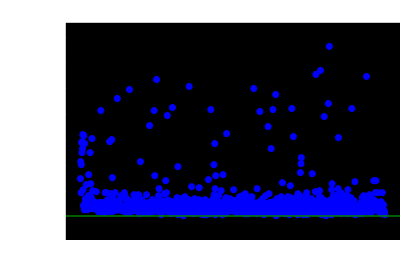

Showing Histogram of 1000 jobs


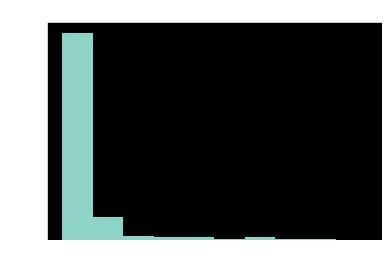

In [11]:
plotting.main_plot_history(trials)
plotting.main_plot_histogram(trials)